In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/MyDrive/ACRIN_lung_cancer_dataset/

/content/gdrive/MyDrive/ACRIN_lung_cancer_dataset


In [3]:
ls

1batch1/   1batch17/  1batch24/  1batch9/
1batch10/  1batch18/  1batch25/  combined_all_SUVmetrics_11_28_25.tsv
1batch11/  1batch19/  1batch3/   combined_all.tsv
1batch12/  1batch2/   1batch4/   combined_data_for_ML.tsv
1batch13/  1batch20/  1batch5/   combined_metadata.tsv
1batch14/  1batch21/  1batch6/   lung_segmentation_2d_model.h5
1batch15/  1batch22/  1batch7/   metadata/
1batch16/  1batch23/  1batch8/


# Step 1: SUV metrics (Tumor severity) Data tidying
- remove rows with NA SUV values
- filter out rows with abnormal SUV values (negative or greater than 100)
- select patients with pre and post treatment SUV values

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df_all = pd.read_csv('combined_all_SUVmetrics_11_28_25.tsv', sep='\t')

In [10]:
df_all.head()

,Patient_ID,Predicted_SUV_max,Predicted_SUV_peak,GT_SUV_max,GT_SUV_peak,Batch
0,ACRIN-NSCLC-FDG-PET-006_1,0.051913,0.019388,0.016849,0.010180,1batch1
1,ACRIN-NSCLC-FDG-PET-006_2,0.068290,0.022984,0.029335,0.014644,1batch1
2,ACRIN-NSCLC-FDG-PET-001_1,28.812275,20.026176,27.734619,19.955622,1batch1
3,ACRIN-NSCLC-FDG-PET-001_2,62.924679,48.975143,65.234947,56.869038,1batch1
4,ACRIN-NSCLC-FDG-PET-007,0.035539,0.027862,0.024952,0.014610,1batch1


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [15]:
df_all = pd.read_csv('combined_all.tsv', sep='\t')


In [22]:
df_all.shape


(380, 6)

In [17]:
df_all.describe()


,Predicted_SUV_max,Predicted_SUV_peak,GT_SUV_max,GT_SUV_peak
count,3.800000e+02,3.800000e+02,3.800000e+02,3.800000e+02
mean,3.060763e+04,2.000579e+04,2.478055e+04,1.435558e+04
std,2.155076e+05,1.502468e+05,2.206775e+05,1.131635e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.107300e-05,4.937218e-06,1.005202e-13,5.243138e-14
50%,3.649472e+00,2.618122e+00,2.462328e+00,1.377998e+00
75%,2.574680e+01,1.980736e+01,1.803095e+01,1.085501e+01
max,2.460814e+06,1.860646e+06,3.792979e+06,1.791309e+06


## Data cleaning

In [25]:
# Make a copy to avoid modifying the original DataFrame
df_cleaned = df_all.copy()

# Define numerical columns for filtering
numerical_cols = ['Predicted_SUV_max', 'Predicted_SUV_peak', 'GT_SUV_max', 'GT_SUV_peak']

# 1. Remove rows with any missing (NA) values
initial_rows = df_cleaned.shape[0]
df_cleaned.dropna(inplace=True)
print(f"Removed {initial_rows - df_cleaned.shape[0]} rows with NA values.")

# 2. Remove rows where all numerical SUV columns are exactly zero
#all_zero_condition = (df_cleaned[numerical_cols] == 0).all(axis=1)
#rows_all_zero = df_cleaned[all_zero_condition].shape[0]
#df_cleaned = df_cleaned[~all_zero_condition]
#print(f"Removed {rows_all_zero} rows where all numerical SUV values were zero.")

# 3. Filter out rows with abnormal SUV values (negative or greater than 100)

# Ensure all numerical values are not greater than 100
less_than_100_condition = (df_cleaned[numerical_cols] <= 100).all(axis=1)
rows_greater_than_100 = df_cleaned[~less_than_100_condition].shape[0]
df_cleaned = df_cleaned[less_than_100_condition]
print(f"Removed {rows_greater_than_100} rows with SUV values greater than 100.")

# 4. Select patients with pre and post treatment SUV values
# Extract base patient ID (without the suffix)
df_cleaned['Patient_Base_ID'] = df_cleaned['Patient_ID'].apply(lambda x: x.split('_')[0] if '_' in x else x)

# Find unique base patient IDs
unique_base_ids = df_cleaned['Patient_Base_ID'].unique()

# Identify base IDs that have both a '_1' (pre) and a '_2' (post) entry
patients_with_pre_post = []
for base_id in unique_base_ids:
    patient_records = df_cleaned[df_cleaned['Patient_Base_ID'] == base_id]
    has_pre = any(p_id.endswith('_1') for p_id in patient_records['Patient_ID'])
    has_post = any(p_id.endswith('_2') for p_id in patient_records['Patient_ID'])
    if has_pre and has_post:
        patients_with_pre_post.append(base_id)

# Filter the DataFrame to keep only these patients
initial_patients = df_cleaned['Patient_Base_ID'].nunique()
df_cleaned = df_cleaned[df_cleaned['Patient_Base_ID'].isin(patients_with_pre_post)]
print(f"Filtered from {initial_patients} unique patients to {df_cleaned['Patient_Base_ID'].nunique()} patients with both pre and post treatment records.")

# Drop the temporary 'Patient_Base_ID' column
df_cleaned = df_cleaned.drop(columns=['Patient_Base_ID'])

print("\nCleaned DataFrame head:")
display(df_cleaned.head())
print("\nCleaned DataFrame shape:", df_cleaned.shape)


Removed 0 rows with NA values.
Removed 39 rows with SUV values greater than 100.
Filtered from 186 unique patients to 127 patients with both pre and post treatment records.

Cleaned DataFrame head:


,Patient_ID,Predicted_SUV_max,Predicted_SUV_peak,GT_SUV_max,GT_SUV_peak,Batch
0,ACRIN-NSCLC-FDG-PET-006_1,0.051913,0.019388,0.016849,0.010180,1batch1
1,ACRIN-NSCLC-FDG-PET-006_2,0.068290,0.022984,0.029335,0.014644,1batch1
2,ACRIN-NSCLC-FDG-PET-001_1,28.812275,20.026176,27.734619,19.955622,1batch1
3,ACRIN-NSCLC-FDG-PET-001_2,62.924679,48.975143,65.234947,56.869038,1batch1
5,ACRIN-NSCLC-FDG-PET-002_1,54.407230,41.071522,59.994946,49.306145,1batch1



Cleaned DataFrame shape: (281, 6)


In [26]:
df_cleaned.describe()

,Predicted_SUV_max,Predicted_SUV_peak,GT_SUV_max,GT_SUV_peak
count,2.810000e+02,2.810000e+02,281.000000,281.000000
mean,1.094754e+01,8.332353e+00,7.593180,4.867809
std,1.767625e+01,1.408413e+01,14.386461,9.630916
min,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,6.343005e-07,3.286673e-07,0.000000,0.000000
50%,1.508333e+00,1.106418e+00,0.483971,0.255178
75%,1.521161e+01,1.143561e+01,7.977873,4.951818
max,9.893810e+01,9.125362e+01,94.818146,61.291229


In [27]:
from google.colab import data_table

data_table.enable_dataframe_formatter()

df_cleaned

,Patient_ID,Predicted_SUV_max,Predicted_SUV_peak,GT_SUV_max,GT_SUV_peak,Batch
0,ACRIN-NSCLC-FDG-PET-006_1,0.051913,0.019388,0.016849,0.010180,1batch1
1,ACRIN-NSCLC-FDG-PET-006_2,0.068290,0.022984,0.029335,0.014644,1batch1
2,ACRIN-NSCLC-FDG-PET-001_1,28.812275,20.026176,27.734619,19.955622,1batch1
3,ACRIN-NSCLC-FDG-PET-001_2,62.924679,48.975143,65.234947,56.869038,1batch1
5,ACRIN-NSCLC-FDG-PET-002_1,54.407230,41.071522,59.994946,49.306145,1batch1
...,...,...,...,...,...,...
371,ACRIN-NSCLC-FDG-PET-236_2,0.000000,0.000000,0.000000,0.000000,1batch24
372,ACRIN-NSCLC-FDG-PET-239_1,0.000000,0.000000,0.000000,0.000000,1batch24
373,ACRIN-NSCLC-FDG-PET-239_2,0.000000,0.000000,0.000000,0.000000,1batch24
378,ACRIN-NSCLC-FDG-PET-233_1,10.575563,9.361037,0.000000,0.000000,1batch24


## Display correlation between predicted tumor severeness (SUV values) and ground truth values

In [32]:
pearson_corr = df_cleaned['Predicted_SUV_peak'].corr(df_cleaned['GT_SUV_peak'])
print(f"Pearson Correlation between Predicted_SUV_max and GT_SUV_max: {pearson_corr:.4f}")

Pearson Correlation between Predicted_SUV_max and GT_SUV_max: 0.7805


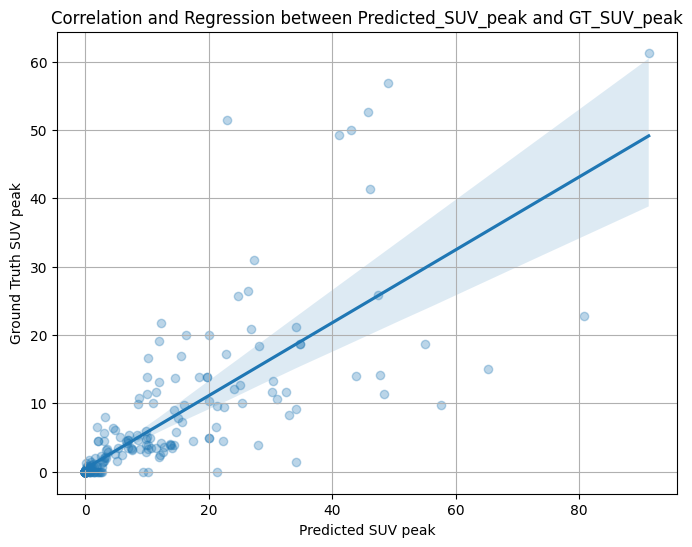

In [33]:
plt.figure(figsize=(8, 6))
sns.regplot(data=df_cleaned, x='Predicted_SUV_peak', y='GT_SUV_peak', scatter_kws={'alpha':0.3})
plt.title('Correlation and Regression between Predicted_SUV_peak and GT_SUV_peak')
plt.xlabel('Predicted SUV peak')
plt.ylabel('Ground Truth SUV peak')
plt.grid(True)
plt.show()

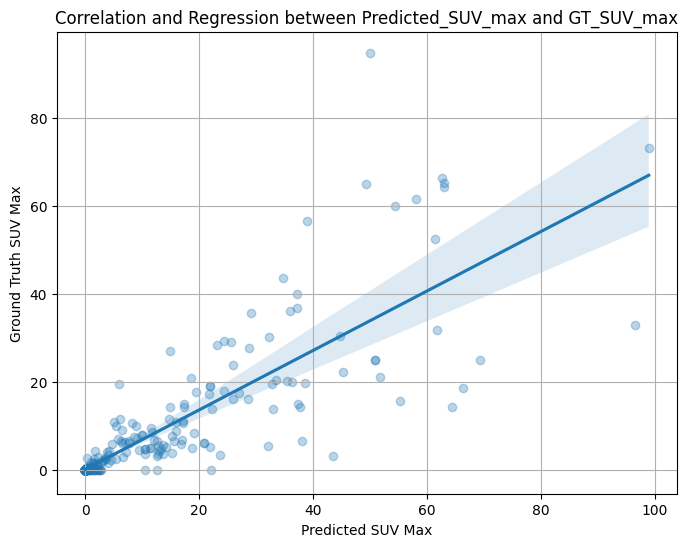

In [31]:
plt.figure(figsize=(8, 6))
sns.regplot(data=df_cleaned, x='Predicted_SUV_max', y='GT_SUV_max', scatter_kws={'alpha':0.3})
plt.title('Correlation and Regression between Predicted_SUV_max and GT_SUV_max')
plt.xlabel('Predicted SUV Max')
plt.ylabel('Ground Truth SUV Max')
plt.grid(True)
plt.show()

In [34]:
# Filter df_cleaned to only include Patient_ID ending with '_1' or '_2' indicating post and pre treatment
df_cleaned_filtered = df_cleaned[df_cleaned['Patient_ID'].str.endswith(('_1', '_2'))]

print("Filtered DataFrame head:")
display(df_cleaned_filtered.head())
print("\nFiltered DataFrame shape:", df_cleaned_filtered.shape)

Filtered DataFrame head:


,Patient_ID,Predicted_SUV_max,Predicted_SUV_peak,GT_SUV_max,GT_SUV_peak,Batch
0,ACRIN-NSCLC-FDG-PET-006_1,0.051913,0.019388,0.016849,0.010180,1batch1
1,ACRIN-NSCLC-FDG-PET-006_2,0.068290,0.022984,0.029335,0.014644,1batch1
2,ACRIN-NSCLC-FDG-PET-001_1,28.812275,20.026176,27.734619,19.955622,1batch1
3,ACRIN-NSCLC-FDG-PET-001_2,62.924679,48.975143,65.234947,56.869038,1batch1
5,ACRIN-NSCLC-FDG-PET-002_1,54.407230,41.071522,59.994946,49.306145,1batch1



Filtered DataFrame shape: (254, 6)


In [42]:
df_plot = df_cleaned_filtered.copy()
df_plot['Patient_Base_ID'] = df_plot['Patient_ID'].apply(lambda x: x.split('_')[0])
df_plot['Time_Point'] = df_plot['Patient_ID'].apply(lambda x: x.split('_')[1])

# Pivot the table to have pre and post values side-by-side
df_pivot = df_plot.pivot_table(index='Patient_Base_ID', columns='Time_Point',
                                 values=['Predicted_SUV_max', 'Predicted_SUV_peak', 'GT_SUV_max', 'GT_SUV_peak'])

df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]
df_pivot.reset_index(inplace=True)

print("Pivoted DataFrame head:")
display(df_pivot.head())
print("\nPivoted DataFrame shape:", df_pivot.shape)

Pivoted DataFrame head:


,Patient_Base_ID,GT_SUV_max_1,GT_SUV_max_2,GT_SUV_peak_1,GT_SUV_peak_2,Predicted_SUV_max_1,Predicted_SUV_max_2,Predicted_SUV_peak_1,Predicted_SUV_peak_2
0,ACRIN-NSCLC-FDG-PET-001,27.734619,65.234947,19.955622,56.869038,28.812275,62.924679,20.026176,48.975143
1,ACRIN-NSCLC-FDG-PET-002,59.994946,64.240448,49.306145,49.923634,54.407230,63.003040,41.071522,43.018654
2,ACRIN-NSCLC-FDG-PET-003,1.659404,2.405111,0.619427,1.292122,1.971839,3.139077,1.470938,2.736062
3,ACRIN-NSCLC-FDG-PET-005,19.777208,20.443424,10.624241,11.661394,38.519787,33.588100,31.136112,30.236721
4,ACRIN-NSCLC-FDG-PET-006,0.016849,0.029335,0.010180,0.014644,0.051913,0.068290,0.019388,0.022984



Pivoted DataFrame shape: (127, 9)


# Step 2: Process the metadata from patients (Age, Weight, clinical records)

In [64]:
cd ..

/content/gdrive/MyDrive/ACRIN_lung_cancer_dataset/metadata


In [65]:
cd TCIA_DATASET_2

/content/gdrive/MyDrive/ACRIN_lung_cancer_dataset/metadata/TCIA_DATASET_2


In [66]:
ls

 A0.csv                                              F1.csv   PR.csv   ST.csv
 A1.csv                                              F2.csv   Q2.csv   T1.csv
'ACRIN 6668 - QIN_6668 Case Sample2018-02-02.xlsx'   I1.csv   QA.csv   TA.csv
'ACRIN 6668 QIN_6668 Data Dictionary.xlsx'           IM.csv   QZ.csv   TF.csv
 AE.csv                                              LE.csv   SF.csv
 DS.csv                                              O1.csv   SS.csv


In [67]:
# read A0 form (Patient registration form)
# Read DS (end of study form)
df_reg = pd.read_csv('A0.csv', sep=',')
df_ds = pd.read_csv('DS.csv', sep=',')

In [68]:
# selcet columns of patient-ID, age, gender, race, cancer stage [a0e36, stage IIB/III]
newcolumns1 =['cn','entryage','a0e11','a0e19','a0e20','a0e21','a0e22','a0e23','a0e24','a0e36']
df_reg_new = df_reg[newcolumns1]

In [69]:
# DSe2d:"Days from Base_dt to DATE OF PREMATURE DISCONTINUATION
# dse3: PRIMARY REASON FOR PREMATURE DISCONTINUATION: 2='Death', 3 =' Lost to follow-up'
newcolumns2 = ['cn','dse3','DSe2d']
df_ds_new = df_ds[newcolumns2]

In [70]:
# Radiation dose: form T1, column t1e13: dose-Total to gross tumor
df_radiation = pd.read_csv('T1.csv', sep=',')
newcolumns3 = ['cn','t1e13']
df_radiation_new = df_radiation[newcolumns3]

In [71]:
# chemotherapy summary
# form TF, columns 'tfe1': YES/NO chemotherapy; 'tfe2': list of drug treatment
df_chemo = pd.read_csv('TF.csv', sep=',')
newcolumns4 = ['cn','tfe1','tfe2']
df_chemo_new = df_chemo[newcolumns4]

In [72]:
# Merge df_reg_new and df_ds_new
df_metadata = pd.merge(df_reg_new, df_ds_new, on='cn', how='left')

# Merge df_metadata with df_radiation_new
df_metadata = pd.merge(df_metadata, df_radiation_new, on='cn', how='left')

# Merge df_metadata with df_chemo_new
df_metadata = pd.merge(df_metadata, df_chemo_new, on='cn', how='left')

print("Combined Metadata DataFrame head:")
display(df_metadata.head())
print("\nCombined Metadata DataFrame shape:", df_metadata.shape)

Combined Metadata DataFrame head:


,cn,entryage,a0e11,a0e19,a0e20,a0e21,a0e22,a0e23,a0e24,a0e36,dse3,DSe2d,t1e13,tfe1,tfe2
0,1,64,1,1,1,1,1,2,1,2,2.0,185.0,63.0,3.0,1.0
1,3,73,1,1,1,1,1,2,1,2,2.0,125.0,64.8,3.0,2.0
2,7,70,2,1,1,1,1,2,1,2,2.0,275.0,6.0,2.0,3.0
3,10,81,1,1,1,1,1,2,1,2,2.0,175.0,28.8,2.0,6.0
4,13,67,1,1,1,1,1,2,1,2,2.0,687.0,63.0,2.0,8.0



Combined Metadata DataFrame shape: (62, 15)


In [73]:
df_metadata.to_csv('combined_metadata_2.tsv', sep='\t', index=False)

In [63]:
df_metadata_1 = df_metadata.copy()

In [76]:
# merge two dataframes
df_merged = pd.concat([df_metadata_1, df_metadata], axis=0)

In [78]:
df_merged.shape

(251, 15)

In [83]:
ls

1batch1/   1batch15/  1batch20/  1batch3/  1batch9/
1batch10/  1batch16/  1batch21/  1batch4/  combined_all_SUVmetrics_11_28_25.tsv
1batch11/  1batch17/  1batch22/  1batch5/  combined_all.tsv
1batch12/  1batch18/  1batch23/  1batch6/  lung_segmentation_2d_model.h5
1batch13/  1batch19/  1batch24/  1batch7/  metadata/
1batch14/  1batch2/   1batch25/  1batch8/


In [84]:
df_merged.to_csv('combined_metadata.tsv', sep='\t', index=False)

# Step3: Merge the SUV metrics data with patients meta data

In [89]:
df_cleaned_filtered

,Patient_ID,Predicted_SUV_max,Predicted_SUV_peak,GT_SUV_max,GT_SUV_peak,Batch
0,ACRIN-NSCLC-FDG-PET-006_1,0.051913,0.019388,0.016849,0.010180,1batch1
1,ACRIN-NSCLC-FDG-PET-006_2,0.068290,0.022984,0.029335,0.014644,1batch1
2,ACRIN-NSCLC-FDG-PET-001_1,28.812275,20.026176,27.734619,19.955622,1batch1
3,ACRIN-NSCLC-FDG-PET-001_2,62.924679,48.975143,65.234947,56.869038,1batch1
5,ACRIN-NSCLC-FDG-PET-002_1,54.407230,41.071522,59.994946,49.306145,1batch1
...,...,...,...,...,...,...
371,ACRIN-NSCLC-FDG-PET-236_2,0.000000,0.000000,0.000000,0.000000,1batch24
372,ACRIN-NSCLC-FDG-PET-239_1,0.000000,0.000000,0.000000,0.000000,1batch24
373,ACRIN-NSCLC-FDG-PET-239_2,0.000000,0.000000,0.000000,0.000000,1batch24
378,ACRIN-NSCLC-FDG-PET-233_1,10.575563,9.361037,0.000000,0.000000,1batch24


In [94]:
# Create a new boolean column 'post' based on the condition
df_pivot['post'] = (df_pivot['GT_SUV_max_1'] > df_pivot['GT_SUV_max_2'])

print("DataFrame with new 'post' column:")
display(df_pivot.head())

DataFrame with new 'post' column:


,Patient_Base_ID,GT_SUV_max_1,GT_SUV_max_2,GT_SUV_peak_1,GT_SUV_peak_2,Predicted_SUV_max_1,Predicted_SUV_max_2,Predicted_SUV_peak_1,Predicted_SUV_peak_2,Treatment_Outcome,post
0,ACRIN-NSCLC-FDG-PET-001,27.734619,65.234947,19.955622,56.869038,28.812275,62.924679,20.026176,48.975143,posttreatment,False
1,ACRIN-NSCLC-FDG-PET-002,59.994946,64.240448,49.306145,49.923634,54.407230,63.003040,41.071522,43.018654,posttreatment,False
2,ACRIN-NSCLC-FDG-PET-003,1.659404,2.405111,0.619427,1.292122,1.971839,3.139077,1.470938,2.736062,posttreatment,False
3,ACRIN-NSCLC-FDG-PET-005,19.777208,20.443424,10.624241,11.661394,38.519787,33.588100,31.136112,30.236721,posttreatment,False
4,ACRIN-NSCLC-FDG-PET-006,0.016849,0.029335,0.010180,0.014644,0.051913,0.068290,0.019388,0.022984,posttreatment,False


In [95]:
# Extract the patient-specific number (removing leading zeros) and create a new column 'entryID'
df_pivot['entryID'] = df_pivot['Patient_Base_ID'].apply(lambda x: str(int(x.split('_')[0].split('-')[-1])))

print("DataFrame with new patient entry column (with leading zeros removed):")
display(df_pivot.head())

DataFrame with new patient entry column (with leading zeros removed):


,Patient_Base_ID,GT_SUV_max_1,GT_SUV_max_2,GT_SUV_peak_1,GT_SUV_peak_2,Predicted_SUV_max_1,Predicted_SUV_max_2,Predicted_SUV_peak_1,Predicted_SUV_peak_2,Treatment_Outcome,post,entryID
0,ACRIN-NSCLC-FDG-PET-001,27.734619,65.234947,19.955622,56.869038,28.812275,62.924679,20.026176,48.975143,posttreatment,False,1
1,ACRIN-NSCLC-FDG-PET-002,59.994946,64.240448,49.306145,49.923634,54.407230,63.003040,41.071522,43.018654,posttreatment,False,2
2,ACRIN-NSCLC-FDG-PET-003,1.659404,2.405111,0.619427,1.292122,1.971839,3.139077,1.470938,2.736062,posttreatment,False,3
3,ACRIN-NSCLC-FDG-PET-005,19.777208,20.443424,10.624241,11.661394,38.519787,33.588100,31.136112,30.236721,posttreatment,False,5
4,ACRIN-NSCLC-FDG-PET-006,0.016849,0.029335,0.010180,0.014644,0.051913,0.068290,0.019388,0.022984,posttreatment,False,6


## Combine the processed SUV metrics df and metadata df

In [96]:
# Convert 'cn' in df_merged to string type to match 'entryID' in df_pivot
df_merged['cn_str'] = df_merged['cn'].astype(str)

# Merge the two DataFrames on 'entryID' and 'cn_str'
df_combined = pd.merge(df_pivot, df_merged, left_on='entryID', right_on='cn_str', how='left')

# Drop the temporary 'cn_str' column if desired, or 'cn' if 'cn_str' is preferred
df_combined = df_combined.drop(columns=['cn_str'])

print("Combined DataFrame head:")
display(df_combined.head())
print("\nCombined DataFrame shape:", df_combined.shape)

Combined DataFrame head:


,Patient_Base_ID,GT_SUV_max_1,GT_SUV_max_2,GT_SUV_peak_1,GT_SUV_peak_2,Predicted_SUV_max_1,Predicted_SUV_max_2,Predicted_SUV_peak_1,Predicted_SUV_peak_2,Treatment_Outcome,...,a0e21,a0e22,a0e23,a0e24,a0e36,dse3,DSe2d,t1e13,tfe1,tfe2
0,ACRIN-NSCLC-FDG-PET-001,27.734619,65.234947,19.955622,56.869038,28.812275,62.924679,20.026176,48.975143,posttreatment,...,1,1,2,1,2,2.0,185.0,63.0,3.0,1.0
1,ACRIN-NSCLC-FDG-PET-002,59.994946,64.240448,49.306145,49.923634,54.407230,63.003040,41.071522,43.018654,posttreatment,...,1,1,2,1,2,2.0,296.0,59.4,3.0,2.0
2,ACRIN-NSCLC-FDG-PET-003,1.659404,2.405111,0.619427,1.292122,1.971839,3.139077,1.470938,2.736062,posttreatment,...,1,1,2,1,2,2.0,125.0,64.8,3.0,2.0
3,ACRIN-NSCLC-FDG-PET-005,19.777208,20.443424,10.624241,11.661394,38.519787,33.588100,31.136112,30.236721,posttreatment,...,1,1,2,1,2,2.0,1289.0,74.0,2.0,2.0
4,ACRIN-NSCLC-FDG-PET-006,0.016849,0.029335,0.010180,0.014644,0.051913,0.068290,0.019388,0.022984,posttreatment,...,1,1,2,1,2,2.0,426.0,68.0,2.0,3.0



Combined DataFrame shape: (127, 27)


In [97]:
df_combined.to_csv('combined_data_for_ML.tsv', sep='\t', index=False)

# Step 4: Train a ML model to predict patient survival time
Prepare the `df_combined` DataFrame for machine learning by selecting features and 'DSe2d' as the target, handling missing values, splitting the data into training and testing sets, and performing one-hot encoding on categorical features. Then, train a RandomForestRegressor model, evaluate its performance using MAE, MSE, and R-squared, and visualize the predictions against actual values. Finally, summarize the model's training, evaluation, and insights from the prediction visualization.

## Prepare Data for Machine Learning

### Subtask:
Select features (X) and target (y = 'DSe2d') from the `df_combined` DataFrame, handle missing values, split the data into training and testing sets, and perform one-hot encoding on categorical features.


**Reasoning**:
The subtask requires preparing the data for machine learning, which involves defining features and targets, handling missing values through imputation, encoding categorical features, and splitting the data into training and testing sets. This code block performs all these preprocessing steps sequentially.



In [5]:
import pandas as pd

In [6]:
df_combined = pd.read_csv('combined_data_for_ML.tsv', sep='\t')

In [7]:
df_combined.head()

,Patient_Base_ID,GT_SUV_max_1,GT_SUV_max_2,GT_SUV_peak_1,GT_SUV_peak_2,Predicted_SUV_max_1,Predicted_SUV_max_2,Predicted_SUV_peak_1,Predicted_SUV_peak_2,Treatment_Outcome,...,a0e21,a0e22,a0e23,a0e24,a0e36,dse3,DSe2d,t1e13,tfe1,tfe2
0,ACRIN-NSCLC-FDG-PET-001,27.734619,65.234947,19.955622,56.869038,28.812275,62.924679,20.026176,48.975143,posttreatment,...,1,1,2,1,2,2.0,185.0,63.0,3.0,1.0
1,ACRIN-NSCLC-FDG-PET-002,59.994946,64.240448,49.306145,49.923634,54.407230,63.003040,41.071522,43.018654,posttreatment,...,1,1,2,1,2,2.0,296.0,59.4,3.0,2.0
2,ACRIN-NSCLC-FDG-PET-003,1.659404,2.405111,0.619427,1.292122,1.971839,3.139077,1.470938,2.736062,posttreatment,...,1,1,2,1,2,2.0,125.0,64.8,3.0,2.0
3,ACRIN-NSCLC-FDG-PET-005,19.777208,20.443424,10.624241,11.661394,38.519787,33.588100,31.136112,30.236721,posttreatment,...,1,1,2,1,2,2.0,1289.0,74.0,2.0,2.0
4,ACRIN-NSCLC-FDG-PET-006,0.016849,0.029335,0.010180,0.014644,0.051913,0.068290,0.019388,0.022984,posttreatment,...,1,1,2,1,2,2.0,426.0,68.0,2.0,3.0


In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# 1. Define the target variable y as the 'DSe2d' column
y = df_combined['DSe2d']

# 2. Define the feature set X by dropping identifier columns and the target column, and only keep the predicted SUV metrics columns
X = df_combined.drop(columns=['DSe2d', 'Patient_Base_ID', 'cn', 'entryID','post','GT_SUV_max_1','GT_SUV_max_2','GT_SUV_peak_1','GT_SUV_peak_2'])

# 3. Drop rows from both X and y where the target variable y is missing
initial_rows_X = X.shape[0]
initial_rows_y = y.shape[0]

missing_y_indices = y.isnull()
X = X[~missing_y_indices]
y = y[~missing_y_indices]

print(f"Removed {initial_rows_X - X.shape[0]} rows due to missing target values.")

# 4. Identify numerical and categorical columns in X
numerical_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(include='object').columns

print(f"Numerical columns: {list(numerical_cols)}")
print(f"Categorical columns: {list(categorical_cols)}")

# 5. For numerical columns in X that have missing values, impute them with the median
median_imputer = SimpleImputer(strategy='median')
X[numerical_cols] = median_imputer.fit_transform(X[numerical_cols])
print("Missing numerical values imputed with median.")

# 6. For categorical columns in X that have missing values, impute them with the mode
mode_imputer = SimpleImputer(strategy='most_frequent')
X[categorical_cols] = mode_imputer.fit_transform(X[categorical_cols])
print("Missing categorical values imputed with mode.")

# Verify no missing values remain
print(f"Missing values in X after imputation: {X.isnull().sum().sum()}")

# 7. Apply one-hot encoding to all categorical columns in X
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform categorical columns
encoded_features = encoder.fit_transform(X[categorical_cols])

# Create a DataFrame from the encoded features with appropriate column names
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols), index=X.index)

# Concatenate the one-hot encoded DataFrame with the original DataFrame (excluding original categorical columns)
X = pd.concat([X.drop(columns=categorical_cols), encoded_df], axis=1)
print("Categorical features one-hot encoded.")

# 8. Split the preprocessed X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nShape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")


Removed 37 rows due to missing target values.
Numerical columns: ['Predicted_SUV_max_1', 'Predicted_SUV_max_2', 'Predicted_SUV_peak_1', 'Predicted_SUV_peak_2', 'entryage', 'a0e11', 'a0e19', 'a0e20', 'a0e21', 'a0e22', 'a0e23', 'a0e24', 'a0e36', 'dse3', 't1e13', 'tfe1', 'tfe2']
Categorical columns: ['Treatment_Outcome']
Missing numerical values imputed with median.
Missing categorical values imputed with mode.
Missing values in X after imputation: 0
Categorical features one-hot encoded.

Shape of X_train: (72, 19)
Shape of X_test: (18, 19)
Shape of y_train: (72,)
Shape of y_test: (18,)


## Use Caret to determine the best ML model

In [29]:
def myCaret_Regression(data):

    from sklearn.model_selection import train_test_split
    # from sklearn.metrics import accuracy_score
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error, explained_variance_score, mean_squared_log_error

    import time

    # Linear Models
    from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor

    # Decision Trees
    from sklearn.tree import DecisionTreeRegressor

    # Support Vector Machines
    from sklearn.svm import SVR

    # Ensemble Methods
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, HistGradientBoostingRegressor

    # Gaussian Processes
    from sklearn.gaussian_process import GaussianProcessRegressor

    # Kernel Ridge Regression
    from sklearn.kernel_ridge import KernelRidge

    # Partial Least Squares
    from sklearn.cross_decomposition import PLSRegression

    ################ List all modesl
    models = [
        LinearRegression(),
        Ridge(),
        Lasso(),
        ElasticNet(),
        BayesianRidge(),
        HuberRegressor(),
        DecisionTreeRegressor(),
        SVR(),
        RandomForestRegressor(),
        GradientBoostingRegressor(),
        AdaBoostRegressor(),
        BaggingRegressor(),
        ## HistGradientBoostingRegressor(), # these models take a long time
        GaussianProcessRegressor(), # these models take a long time
        KernelRidge(),
        PLSRegression()
    ]
    ################

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.25, random_state=0)

    df_results = pd.DataFrame(columns=['Model', 'MSE', 'MAE', 'R2', 'ME', 'EV', 'MAPE', 'Time (sec)'])

    # Train and evaluate each model
    for model in models:
        start_time = time.time()
        print("Now working on the model: ", model.__class__.__name__)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        max_err = max_error(y_test, y_pred)
        explained_variance = explained_variance_score(y_test, y_pred)
        # rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
        mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
        end_time = time.time()
        elapsed_time = end_time - start_time
        # Create a new row with model name and MSE, Time, and append it to the DataFrame
        new_row = pd.DataFrame({'Model': [model.__class__.__name__], 'MSE': [mse], 'MAE': [mae], 'R2': [r2], 'ME': [max_err], 'EV': [explained_variance],  'MAPE': [mape], 'Time (sec)': [elapsed_time] })
        df_results = pd.concat([df_results, new_row], ignore_index=True)
    #print(df_results.sort_values('MSE'))
    return df_results

In [30]:
df = X
df['target'] = y

In [31]:
df.head()

,Predicted_SUV_max_1,Predicted_SUV_max_2,Predicted_SUV_peak_1,Predicted_SUV_peak_2,entryage,a0e11,a0e19,a0e20,a0e21,a0e22,a0e23,a0e24,a0e36,dse3,t1e13,tfe1,tfe2,Treatment_Outcome_posttreatment,Treatment_Outcome_pretreatment,target
0,28.812275,62.924679,20.026176,48.975143,64.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,63.0,3.0,1.0,1.0,0.0,185.0
1,54.407230,63.003040,41.071522,43.018654,61.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,59.4,3.0,2.0,1.0,0.0,296.0
2,1.971839,3.139077,1.470938,2.736062,73.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,64.8,3.0,2.0,1.0,0.0,125.0
3,38.519787,33.588100,31.136112,30.236721,78.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,74.0,2.0,2.0,1.0,0.0,1289.0
4,0.051913,0.068290,0.019388,0.022984,77.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,68.0,2.0,3.0,1.0,0.0,426.0


In [32]:
dfresults = myCaret_Regression(df)

Now working on the model:  LinearRegression
Now working on the model:  Ridge
Now working on the model:  Lasso
Now working on the model:  ElasticNet
Now working on the model:  BayesianRidge
Now working on the model:  HuberRegressor
Now working on the model:  DecisionTreeRegressor
Now working on the model:  SVR
Now working on the model:  RandomForestRegressor


/tmp/ipython-input-1592758025.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, new_row], ignore_index=True)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Now working on the model:  GradientBoostingRegressor
Now working on the model:  AdaBoostRegressor
Now working on the model:  BaggingRegressor
Now working on the model:  GaussianProcessRegressor
Now working on the model:  KernelRidge
Now working on the model:  PLSRegression


In [33]:
dfresults.sort_values('MSE')

,Model,MSE,MAE,R2,ME,EV,MAPE,Time (sec)
3,ElasticNet,129712.203546,279.516279,0.029735,1008.617323,0.030369,65.920645,0.009588
2,Lasso,130662.294477,281.334128,0.022628,1031.779084,0.040520,60.903137,0.009749
14,PLSRegression,131220.199301,273.833623,0.018455,1020.118425,0.048169,61.681097,0.008280
0,LinearRegression,131373.392481,282.770444,0.017309,1037.591834,0.037874,60.644077,0.016527
1,Ridge,133142.277498,279.473716,0.004077,1035.358088,0.018267,62.891997,0.009890
4,BayesianRidge,133894.417718,283.377861,-0.001549,1036.051963,0.000145,68.862721,0.010807
13,KernelRidge,136339.078251,281.239288,-0.019835,1057.735019,-0.004956,63.021767,0.008281
10,AdaBoostRegressor,136542.440618,301.922839,-0.021356,838.363636,0.011553,68.181235,0.140619
11,BaggingRegressor,139283.074783,299.930435,-0.041857,833.700000,0.018920,64.878083,0.044310
8,RandomForestRegressor,146999.095322,305.704348,-0.099573,965.960000,-0.039392,66.365866,0.290952


# Step 5: The best model is ElasticNet


**Reasoning**:
The subtask requires training an ElasticNet regression model using the prepared training data.



In [35]:
from sklearn.linear_model import ElasticNet

# 1. Initialize an ElasticNet regression model
elastic_model = ElasticNet(random_state=42)

# 2. Train the model using the fit() method
elastic_model.fit(X_train, y_train)

print("ElasticNet regression model trained successfully.")

ElasticNet regression model trained successfully.


**Reasoning**:
The subtask requires evaluating the trained ElasticNet model using Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared, and visualizing the actual vs. predicted 'DSe2d' values. This involves making predictions on the test set, calculating these metrics, and creating relevant plots.



In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Make predictions on the test set
y_pred_elastic = elastic_model.predict(X_test)

# 2. Calculate evaluation metrics for ElasticNet
mae_elastic = mean_absolute_error(y_test, y_pred_elastic)
mse_elastic = mean_squared_error(y_test, y_pred_elastic)
r2_elastic = r2_score(y_test, y_pred_elastic)

print(f"LR Model Evaluation:\n")
print(f"Mean Absolute Error (MAE): {mae_elastic:.2f}")
print(f"Mean Squared Error (MSE): {mse_elastic:.2f}")
print(f"R-squared (R2): {r2_elastic:.2f}")

LR Model Evaluation:

Mean Absolute Error (MAE): 317.03
Mean Squared Error (MSE): 124257.87
R-squared (R2): -0.49


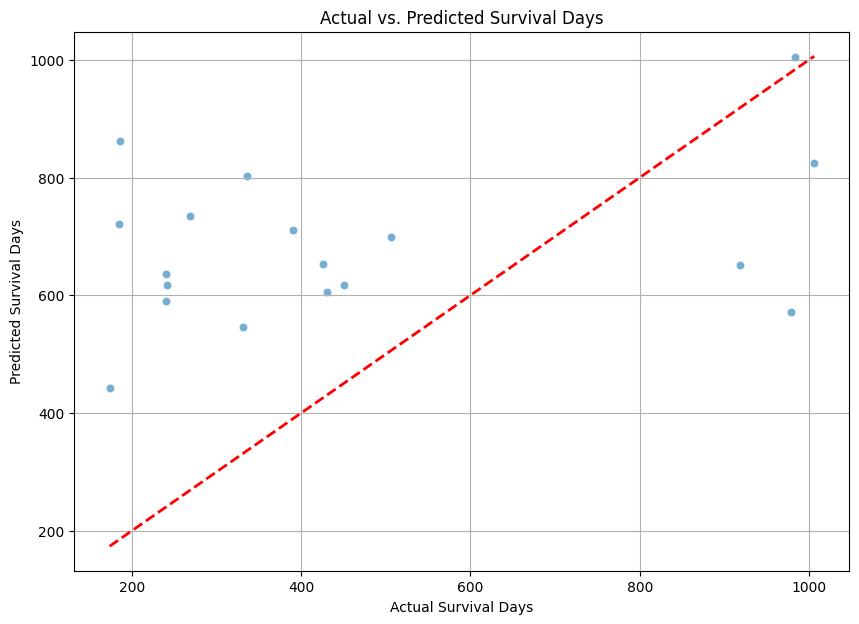

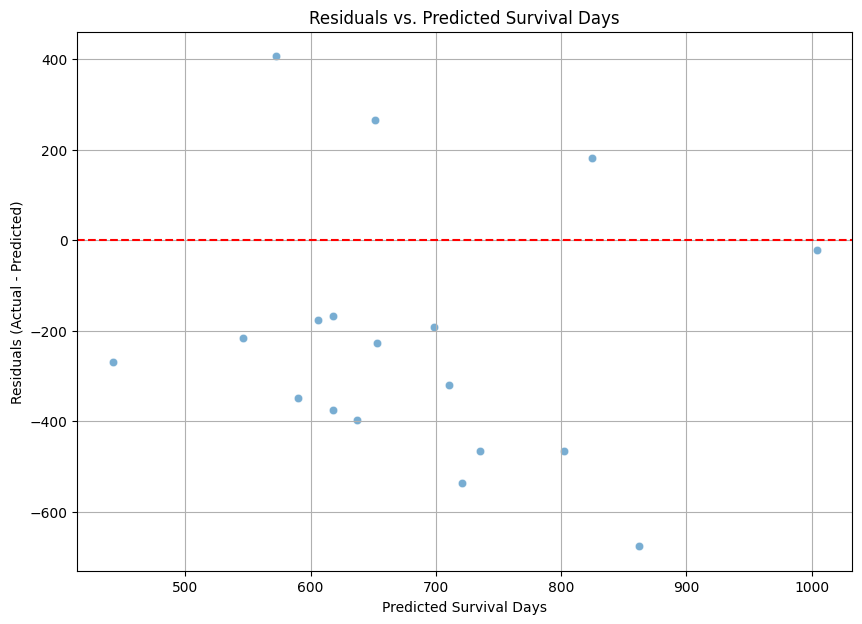

In [37]:
# 3. Create a scatter plot of actual vs. predicted values for ElasticNet
plt.figure(figsize=(10, 7))
sns.scatterplot(x=y_test, y=y_pred_elastic, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Add a diagonal line for perfect prediction
plt.title('Actual vs. Predicted Survival Days')
plt.xlabel('Actual Survival Days')
plt.ylabel('Predicted Survival Days')
plt.grid(True)
plt.show()

# 4. Optionally, create a residual plot to check for patterns in errors
residuals_elastic = y_test - y_pred_elastic
plt.figure(figsize=(10, 7))
sns.scatterplot(x=y_pred_elastic, y=residuals_elastic, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Survival Days')
plt.xlabel('Predicted Survival Days')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()

# Step 6:  Feature Importance for Linear Regression Model

/tmp/ipython-input-138104678.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances_elastic_sorted.values, y=feature_importances_elastic_sorted.index, palette='plasma')


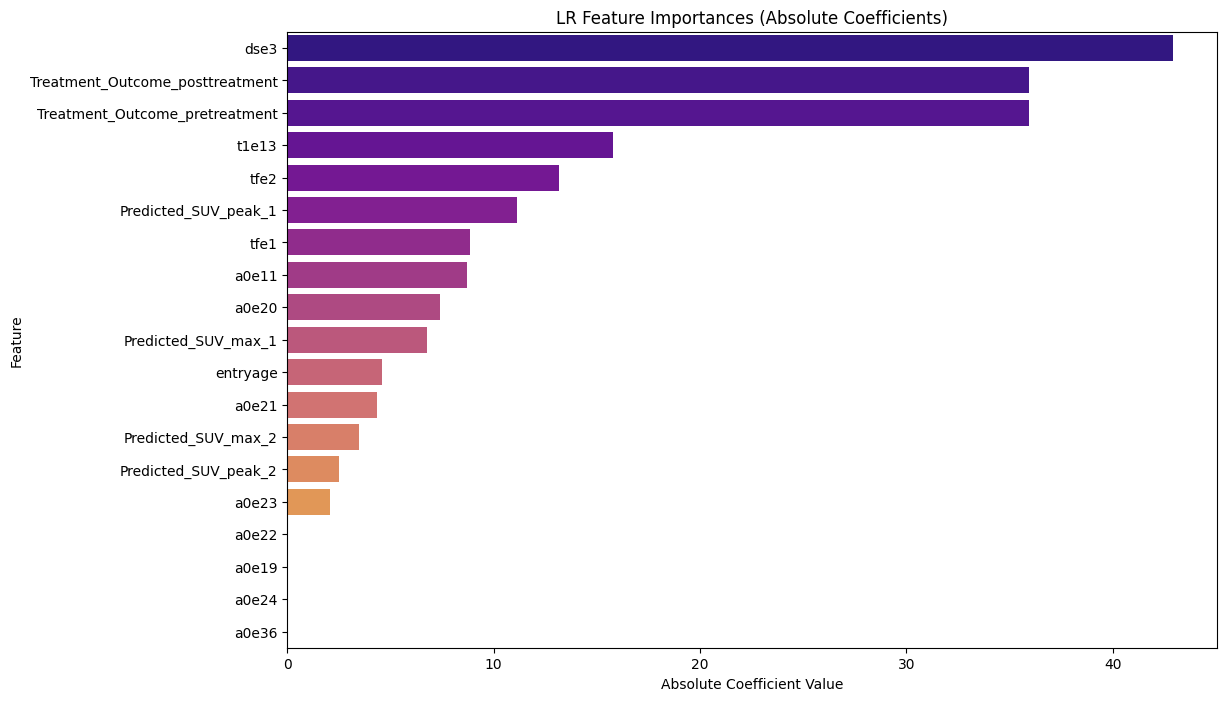

Top 10 ElasticNet Features:


,0
dse3,42.922845
Treatment_Outcome_posttreatment,35.942576
Treatment_Outcome_pretreatment,35.942080
t1e13,15.762405
tfe2,13.157863
Predicted_SUV_peak_1,11.135354
tfe1,8.845178
a0e11,8.704175
a0e20,7.422820
Predicted_SUV_max_1,6.777338


In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get coefficients from the trained ElasticNet model
# Take absolute values to represent importance magnitude
feature_importances_elastic = pd.Series(np.abs(elastic_model.coef_), index=X_train.columns)

# Sort feature importances in descending order
feature_importances_elastic_sorted = feature_importances_elastic.sort_values(ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances_elastic_sorted.values, y=feature_importances_elastic_sorted.index, palette='plasma')
plt.title('LR Feature Importances (Absolute Coefficients)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()

print("Top 10 ElasticNet Features:")
display(feature_importances_elastic_sorted.head(10))